In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import os,sys
import re
import math
from datetime import datetime
import time
sys.dont_write_bytecode = True

# Rotated MNIST dataset
Jan 22, 2021

Equivalent to MonoMNIST, but with rotation angle as the "domain" / style.


In [ ]:
import pandas as pd

import numpy as np
import joblib
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Any, List, Set, Dict, Tuple, Optional, Iterable, Mapping, Union, Callable, TypeVar

from pprint import pprint
from ipdb import set_trace as brpt

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from  torch.linalg import norm as tnorm
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.tuner.tuning import Tuner


# Select Visible GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="3"

## Set Path 
1. Add project root and src folders to `sys.path`
2. Set DATA_ROOT to `maptile_v2` folder

In [ ]:
this_nb_path = Path(os.getcwd())
ROOT = this_nb_path.parent
SRC = ROOT/'src'
DATA_ROOT = Path("/data/hayley-old/maptiles_v2/")
paths2add = [this_nb_path, ROOT]

print("Project root: ", str(ROOT))
print('Src folder: ', str(SRC))
print("This nb path: ", str(this_nb_path))


for p in paths2add:
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))
        print(f"\n{str(p)} added to the path.")
# print(sys.path)

In [ ]:
from src.data.datasets.utils import get_mnist_data
from src.data.datasets.rotated_mnist import RotatedMNIST
from src.data.datasets.multisource_rotated_mnist import MultiRotatedMNIST

from src.data.transforms.transforms import Identity, Unnormalizer, LinearRescaler, Monochromizer
from src.data.transforms.functional import unnormalize, to_monochrome

from src.visualize.utils import show_timg, show_timgs, show_batch, make_grid_from_tensors
from src.utils.misc import info
from collections import OrderedDict, defaultdict
from PIL import Image

In [ ]:
from PIL.Image import Image

In [ ]:
import torchvision.transforms.functional as TF


## Load Rotated MNIST data from `npy` files in DIVA's repo



In [ ]:
diva_data_dir = Path('/data/hayley-old/Github/DIVA/paper_experiments/rotated_mnist/dataset')
diva_data_dir.exists()

In [ ]:
diva_seed = '0'
inds_fn = diva_data_dir/f'supervised_inds_{diva_seed}.npy'
inds = np.load(inds_fn)

## Test rotated mnist dataset class

In [ ]:
data_root = '/data/hayley-old/Tenanbaum2000/data'
ds_30 = RotatedMNIST(data_root, 30)
ds_45 = RotatedMNIST(data_root, 45)
ds_0 = RotatedMNIST(data_root, 0)
ds_n30 = RotatedMNIST(data_root, -30)
ds_n45 = RotatedMNIST(data_root, -45)

In [ ]:
ds = ds_0
print("angle: ", ds_0.angle)

for i in range(10):
    ind = np.random.choice(len(ds))
    sample = ds[ind]
    x, y, d = ds.unpack(sample)
    show_timg(x)
    plt.title(f"Digit: {y}, Angle: {d}")


Let's test RotatedMNIST dataset with various angles

In [ ]:
angles = [45, 30, 0, -30, -45]
dsets = {}
for angle in angles:
    dsets[angle] = RotatedMNIST(data_root, angle)
    

In [ ]:
for angle, dset in dsets.items():
    print("angle: ", angle, dset.angle)
    ind = np.random.choice(len(dset))
    sample = dset[ind]
    x, y, d = dset.unpack(sample)
    show_timg(x)
    plt.title(f"Digit: {y}, Angle: {d}")
    

We can now specify which indices of the original MNIST dataset we want to only include (and then rotate those selected images)
- Updated: May 24, 2021

In [14]:
ds_test = RotatedMNIST(
    data_root=data_root, 
    angle=30, 
    selected_inds=inds
)
len(ds_30), len(ds_test)

angle:  30  , type:  <class 'int'>


(60000, 1000)

Tests

- [x] check if these iamges are actually the images in the diva -- whwen I directly import from there

In [15]:
ds_test = RotatedMNIST(
    data_root=data_root, 
    angle=0, 
    selected_inds=inds
)
len(ds_test)

# Load all original MNIST dataset and digit labels (in a deterministic order)
# to verify our "selected_inds" are in sync with the correct data used in 
# DIVA's experiments
all_pil_imgs, all_digit_labels = get_mnist_data(data_root) 

angle:  0  , type:  <class 'int'>


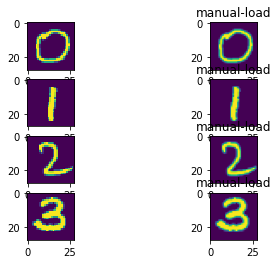

In [16]:
inds_show = [0,101,201,301]
# inds_show = [8,111,221,331]
# inds_show = [3,121,231,341]

n_show = len(inds_show)
f, axes = plt.subplots(n_show, 2)
    
for i, ind in enumerate(inds_show): #random inds to show
    sample = ds_test[ind]
    x,y,d = ds_test.unpack(sample)

#     axes[i, 0] = show_timg(x, title=f"Digit: {y}, Angle: {d}")
    axes[i, 0].imshow(
        np.transpose(x.numpy(), (1, 2, 0)),
        interpolation='nearest',
    )
    axes[i, 1].imshow(all_pil_imgs[inds[ind]])
    axes[i, 1].set_title('manual-load')


Looks good!:)


- [ ] check the result of using this modified RotatedMnist with selected-inds as part of input args -- in multi rotated mnist datamodule

## Multisource Rotated MNIST dataset
A dataset created by concatenating multiple RotatedMNIST datasets



In [22]:
from src.data.datasets.multisource_rotated_mnist import MultiRotatedMNIST

In [23]:
data_root = '/data/hayley-old/Tenanbaum2000/data'
angles = [0,60]
ds = MultiRotatedMNIST(
    data_root=data_root, 
    angles=angles,
    selected_inds=inds,
)

angle:  0  , type:  <class 'int'>
angle:  60  , type:  <class 'int'>


In [19]:
print(ds[0]['angle'], ds[-1]['angle'])
print(len(ds))


0 1
2000


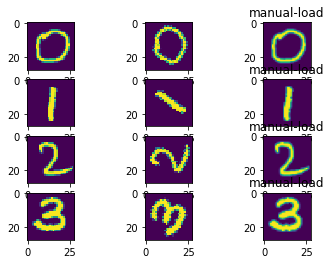

In [20]:
inds_show = [0,101,201,301]
# inds_show = [8,111,221,331]
# inds_show = [3,121,231,341]

n_show = len(inds_show)

f, axes = plt.subplots(n_show, 3)
for i, ind in enumerate(inds_show): #random inds to show
    angle0_sample = ds.dsets[0][ind]
    angle1_sample = ds.dsets[1][ind]


    angle0_x,_,_ = ds.unpack(angle0_sample)
    angle1_x,_,_ = ds.unpack(angle1_sample)


#     axes[i, 0] = show_timg(x, title=f"Digit: {y}, Angle: {d}")
    axes[i, 0].imshow(
        np.transpose(angle0_x.numpy(), (1, 2, 0)),
        interpolation='nearest',
    )
    
    axes[i, 1].imshow(
        np.transpose(angle1_x.numpy(), (1, 2, 0)),
        interpolation='nearest',
    )
    axes[i, 2].imshow(all_pil_imgs[inds[ind]])
    axes[i, 2].set_title('manual-load')



# for i in range(n_samples):
#     ind = np.random.choice(len(ds))
#     sample = ds[ind]
#     x, y, d = ds.unpack(sample)
#     show_timg(x)
#     plt.title(f"Digit: {y}, Angle: {d}")
    

IndexError: index 1000 is out of bounds for dimension 0 with size 16

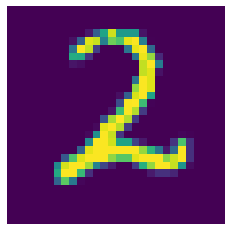

In [21]:
bs = 16
dl = DataLoader(ds, batch_size=bs, shuffle=True,
               num_workers=16, pin_memory=True)
for batch in dl:
    x,y,d = ds.unpack(batch)
    for i in range(len(x)):
        show_timg(x[i])
        plt.title(
            f"Digit: {y[i]}, Angle-label {d[i]} ({ds.idx2angle[int(d[i])]})"
        )
        plt.show()
    break

## Multisource Rotated MNIST Datamodule

### Final Workflow
- Specify dataset settings 
  - colors, batch_size, shape of each datapoint (`in_shape`)
- Optionally, specify the indices (of the original MNIST dataset) to be included in the rotation data
  - use the pre-computed indices from DIVA's experiments
- Initialize a multisource MonoMNIST dataset
- Initialize a multisource MonoMNIST datamodule using the dataset

In [43]:
from src.data.datamodules.multisource_rotated_mnist_datamodule import MultiRotatedMNISTDataModule

In [ ]:
# Load Rotated MNIST data from `npy` files in DIVA's repo
diva_data_dir = Path('/data/hayley-old/Github/DIVA/paper_experiments/rotated_mnist/dataset')
diva_seed = '0'
inds_fn = diva_data_dir/f'supervised_inds_{diva_seed}.npy'
inds = np.load(inds_fn)

In [25]:
# Dataset settings
data_dir = Path("/data/hayley-old/Tenanbaum2000/data/")
angles = [0, 30]
seed = 123
in_shape = (1, 32, 32)
batch_size = 32



In [27]:
# Create a concat dataset from multiple mono-mnist datasets
ds = MultiRotatedMNIST(
    data_root=data_dir,
    angles=angles,
    selected_inds=inds,
)
print("===Num. of observations===")
print([len(d) for d in ds.dsets])

angle:  0  , type:  <class 'int'>
angle:  30  , type:  <class 'int'>
===Num. of observations===
[1000, 1000]


In [44]:
# Create a multisource rotated-mnist datamodule
# dm = MultiRotatedMNISTDataModule(
#     data_root=data_dir,
#     angles=angles,
#     selected_inds=inds,
#     in_shape=in_shape,
#     batch_size=batch_size,
#     shuffle=True,
#     split_seed=seed,
# )

# Alternatively, use the filepath to the index file (npy)
diva_data_dir = Path('/data/hayley-old/Github/DIVA/paper_experiments/rotated_mnist/dataset')
diva_seed = '0'
inds_fn = diva_data_dir/f'supervised_inds_{diva_seed}.npy'

dm = MultiRotatedMNISTDataModule(
    data_root=data_dir,
    angles=angles,
    selected_inds_fp=inds_fn,
    in_shape=in_shape,
    batch_size=batch_size,
    shuffle=True,
    split_seed=seed,
)
dm.setup('fit')

angle:  0  , type:  <class 'int'>
angle:  30  , type:  <class 'int'>


In [61]:
len(dm.train_ds), len(dm.val_ds)

(1400, 600)

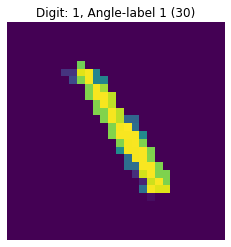

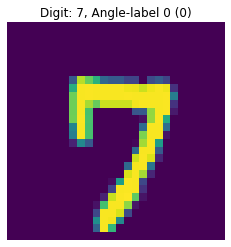

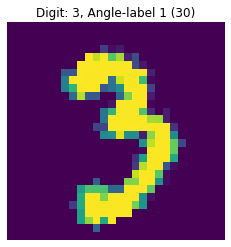

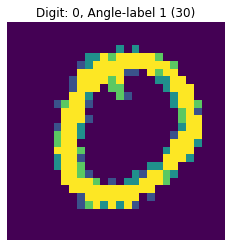

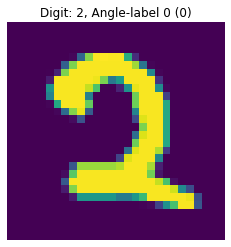

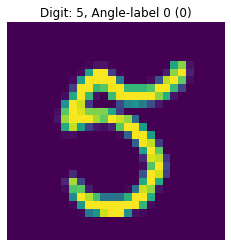

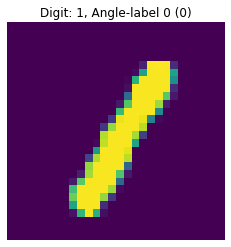

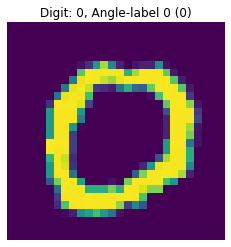

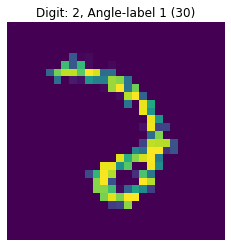

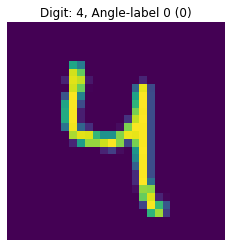

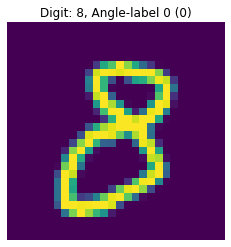

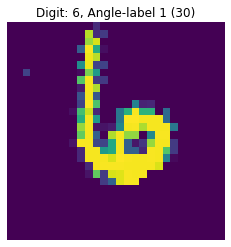

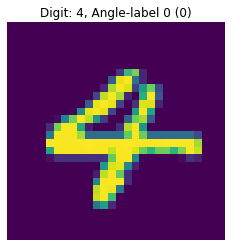

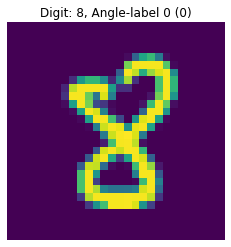

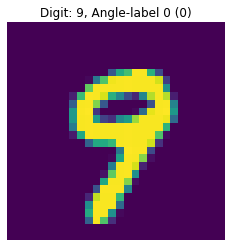

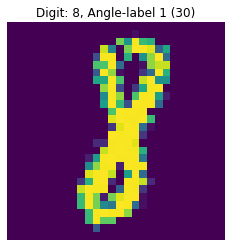

In [46]:
bs = 16
dl = DataLoader(ds, batch_size=bs, shuffle=True,
               num_workers=1, pin_memory=True)
for batch in dl:
    x,y,d = ds.unpack(batch)
    for i in range(len(x)):
        show_timg(x[i])
        plt.title(
            f"Digit: {y[i]}, Angle-label {d[i]} ({ds.idx2angle[int(d[i])]})"
        )
        plt.show()
    break

In [47]:
dm.name
dl = dm.train_dataloader()

tensor([0, 2, 5, 4, 7, 1, 7, 1, 7, 4, 9, 2, 1, 6, 6, 0, 4, 5, 1, 9, 0, 6, 1, 3,
        2, 1, 2, 6, 1, 4, 2, 0])
tensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 1])
===


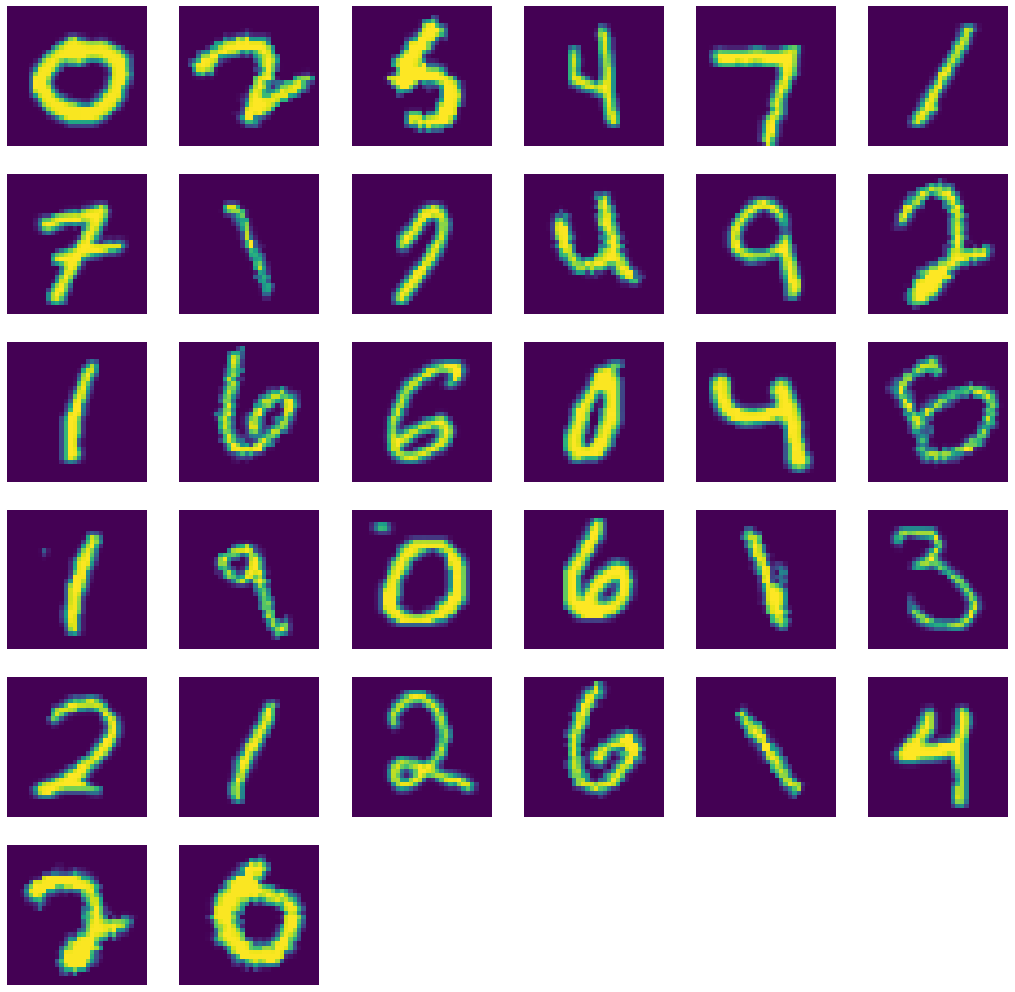

In [48]:
# Show a batch
batch = next(iter(dl))
x, label_c, label_s = dm.unpack(batch)
show_timgs(x)
print(label_c)
print(label_s)
print("===")

May 24, 2021 

12:12pm

- Train BIVAE on MNISTRotated data -- use 12-a
- Evaluate the model
    - set the test data to the held-out angle -- this can be done by 
    - create a new datamodule for evaluation: dm = MultiRotatedMNIST(
        angle="angle that we did not include in the training datamodule",
        
    )
- Get the side-by-side embedding result by setting dim_latent = 2 
     - compare it with Fig2 of DIVA paper
     
- Get the accuracy for the task of: predict domain label
- Get the accuracy of the task of: predict the content label based on Z_c vs. DIVA

- Create a new pl.lightning module of DIVA
- for... what?

    

In [57]:
from src.data.datamodules.multisource_rotated_mnist_datamodule import MultiRotatedMNISTDataModule